In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns

# Residuals analysis

In [2]:
bike = pd.read_csv('bike_sharing_train.csv')
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
bike.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [5]:
bike.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
# bike data에서 taarget 제거
data = bike.drop(columns='count')

# datetime 컬럼을 datetime 타입으로 변환
data['datetime'] = pd.to_datetime(data['datetime'])

# 1. 요일 추출 → day 컬럼에 저장 (0=월요일, 6=일요일)
data['day'] = data['datetime'].dt.weekday.astype('category')

# 2. year, month 추출
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month

# 3. season, weather를 카테고리형으로 변환
data['season'] = data['season'].astype('category')
data['weather'] = data['weather'].astype('category')

# 4. datetime column 드롭 X로 저장
data = data.drop(columns='datetime')

# 5. y target 
X = data.copy()
y = bike['count']

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  day         10886 non-null  category
 11  year        10886 non-null  int32   
 12  month       10886 non-null  int32   
dtypes: category(3), float64(3), int32(2), int64(5)
memory usage: 798.1 KB


In [8]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10886 entries, 0 to 10885
Series name: count
Non-Null Count  Dtype
--------------  -----
10886 non-null  int64
dtypes: int64(1)
memory usage: 85.2 KB


In [9]:
# Categorical variables one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [10]:
X.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,year,month,...,season_4,weather_2,weather_3,weather_4,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0,9.84,14.395,81,0.0,3,13,2011,1,...,False,False,False,False,False,False,False,False,True,False
1,0,0,9.02,13.635,80,0.0,8,32,2011,1,...,False,False,False,False,False,False,False,False,True,False
2,0,0,9.02,13.635,80,0.0,5,27,2011,1,...,False,False,False,False,False,False,False,False,True,False
3,0,0,9.84,14.395,75,0.0,3,10,2011,1,...,False,False,False,False,False,False,False,False,True,False
4,0,0,9.84,14.395,75,0.0,0,1,2011,1,...,False,False,False,False,False,False,False,False,True,False


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10886 non-null  int64  
 1   workingday  10886 non-null  int64  
 2   temp        10886 non-null  float64
 3   atemp       10886 non-null  float64
 4   humidity    10886 non-null  int64  
 5   windspeed   10886 non-null  float64
 6   casual      10886 non-null  int64  
 7   registered  10886 non-null  int64  
 8   year        10886 non-null  int32  
 9   month       10886 non-null  int32  
 10  season_2    10886 non-null  bool   
 11  season_3    10886 non-null  bool   
 12  season_4    10886 non-null  bool   
 13  weather_2   10886 non-null  bool   
 14  weather_3   10886 non-null  bool   
 15  weather_4   10886 non-null  bool   
 16  day_1       10886 non-null  bool   
 17  day_2       10886 non-null  bool   
 18  day_3       10886 non-null  bool   
 19  day_4       10886 non-nul

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,year,month,...,season_4,weather_2,weather_3,weather_4,day_1,day_2,day_3,day_4,day_5,day_6
2815,0,1,27.88,31.820,83,6.0032,5,30,2011,7,...,False,False,False,False,False,True,False,False,False,False
8695,0,0,36.90,40.910,39,19.9995,197,253,2012,8,...,False,False,False,False,False,False,False,False,True,False
8406,0,1,32.80,35.605,41,16.9979,56,220,2012,7,...,False,False,False,False,False,True,False,False,False,False
1543,0,0,14.76,18.180,93,7.0015,3,2,2011,4,...,False,True,False,False,False,False,False,False,False,True
4952,0,0,13.12,15.150,45,16.9979,35,165,2011,11,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,0,6.56,8.335,47,11.0014,6,32,2012,1,...,False,False,False,False,False,False,False,False,True,False
5191,0,0,11.48,12.880,61,19.0012,15,134,2011,12,...,True,False,False,False,False,False,False,False,True,False
5390,0,0,11.48,13.635,48,16.9979,27,207,2011,12,...,True,False,False,False,False,False,False,False,False,True
860,0,0,15.58,19.695,17,35.0008,6,16,2011,2,...,False,False,False,False,False,False,False,False,True,False


In [14]:
# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [15]:
# 예측
y_pred = model.predict(X_test)

In [16]:
# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'R²: {r2}')

MSE: 7.308762574432847e-25
R²: 1.0


In [17]:
# 잔차 = 실제값 - 예측값
residuals = y_test - y_pred

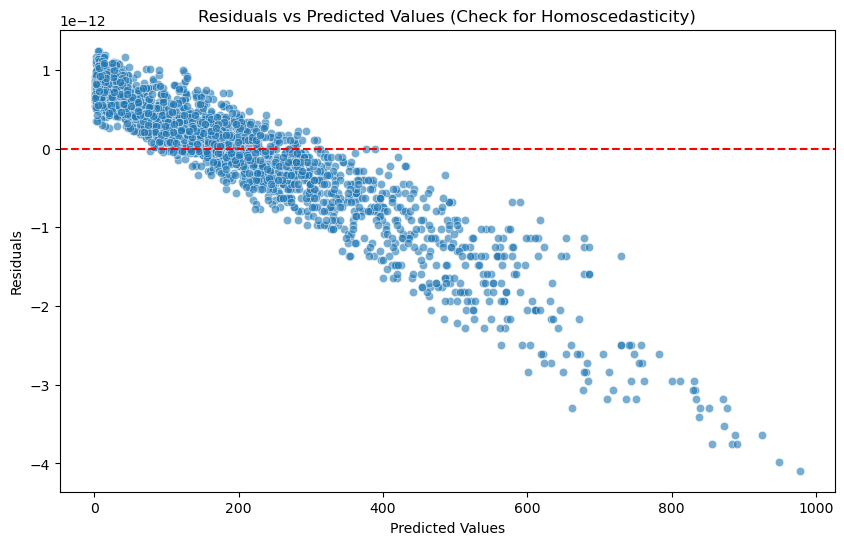

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Check for Homoscedasticity)')
plt.show()

- 예측은 거의 정확한데 오차의 등분산성 만족하지 않음.

## Problem 1. 너무 좋은 성능? 반면 오차는들의 분산을 우하향
- MSE = 0
- R2 = 1
- 오차간 등분산성은 만족하지 않음

- Data leakage 의심

In [23]:
# 'casual'과 'resistered'를 포함한 데이터 (target leakage)
data_with_count = data.copy()
data_with_count['count'] = y

In [19]:
# VIF 계산 함수
def calculate_vif(df):
    # 상수항 추가 (회귀분석용)
    X = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [
        variance_inflation_factor(X.values, i+1)  # +1은 상수항 건너뜀
        for i in range(df.shape[1])
    ]
    return vif_data

In [21]:
# 예시: data 라는 DataFrame 사용
vif_df = calculate_vif(data_with_count).sort_values('VIF', ascending=False)

vif_df

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
8,casual,inf
9,registered,inf
13,count,inf
5,atemp,35.954383
4,temp,35.832522
12,month,18.289059
0,season,18.120611
2,workingday,3.224679
10,day,2.820965
6,humidity,1.672750


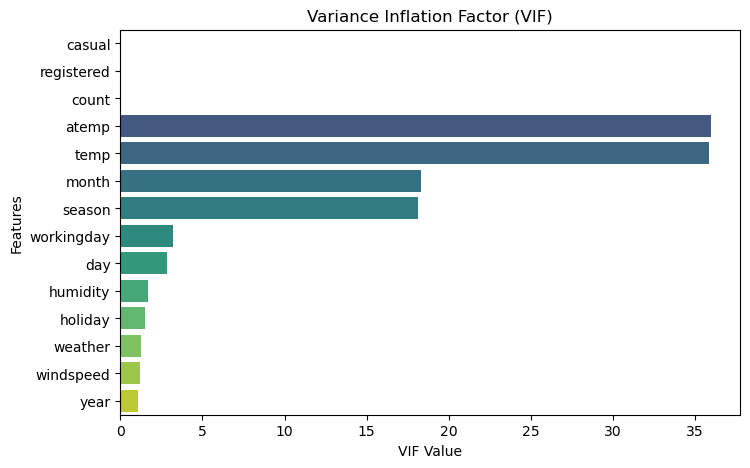

In [22]:
# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    x='VIF', y='feature',
    data=vif_df,
    hue='feature',        # 색상 기준 지정
    dodge=False,          # hue에 따른 위치 분리 방지
    palette='viridis',
    legend=False          # 범례 숨김
)
plt.title('Variance Inflation Factor (VIF)')
plt.xlabel("VIF Value")
plt.ylabel("Features")
plt.show()

In [26]:
data_with_count.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,day,year,month,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,5,2011,1,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,5,2011,1,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,5,2011,1,32


- 'casual' 과  'registered'가 정확한 단서를 주고있음
    - 'casual' + 'registered' = 'count'(target)
- 'casual'과 'resistered'는 모두 drop

In [30]:
object_data = data.drop(columns=['casual', 'registered'])
object_data.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,year,month
0,1,0,0,1,9.84,14.395,81,0.0,5,2011,1
1,1,0,0,1,9.02,13.635,80,0.0,5,2011,1


In [31]:
# 예시: data 라는 DataFrame 사용
vif_df = calculate_vif(object_data).sort_values('VIF', ascending=False)

In [32]:
vif_df

,feature,VIF
5,atemp,35.815878
4,temp,35.750188
10,month,18.209038
0,season,18.111312
2,workingday,2.892474
8,day,2.820426
1,holiday,1.520427
6,humidity,1.449607
3,weather,1.237989
7,windspeed,1.201620


- 'temp'와 'attemp'간에도 높은 공선성을 보임

In [33]:
X_train = X_train.drop(columns=['casual', 'registered'])
X_test = X_test.drop(columns=['casual', 'registered'])

In [34]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')
print(f'R²: {r2}')

residuals = y_test - y_pred

MSE: 21946.687499171185
RMSE: 148.14414432967368
R²: 0.33508861322632544


## 문제 2. 너무 낮은 예측 성능
- 다중 공선성 때문일까? (temp, atemp)

In [35]:
y_test.describe()

count    2178.000000
mean      191.531680
std       181.719833
min         1.000000
25%        41.000000
50%       145.000000
75%       280.000000
max       977.000000
Name: count, dtype: float64

- 모델의 적합도가 매우 낮다 (낮은 R2, 높은 MSE)
    - 모델이 데이터를 잘 설명하지 못하고 있다.
- 모델 오차(RMSE = 148.2)가 데이터의 평균 (MEAN = 191.5)의 77% 수준
- 모델 오차(RMSE = 148.2)가 데이터의 자연 변동성(std = 181.7)에 거의 맞먹음
    - 즉, 예측값이 평균을 찍느니만 못할 수 있음

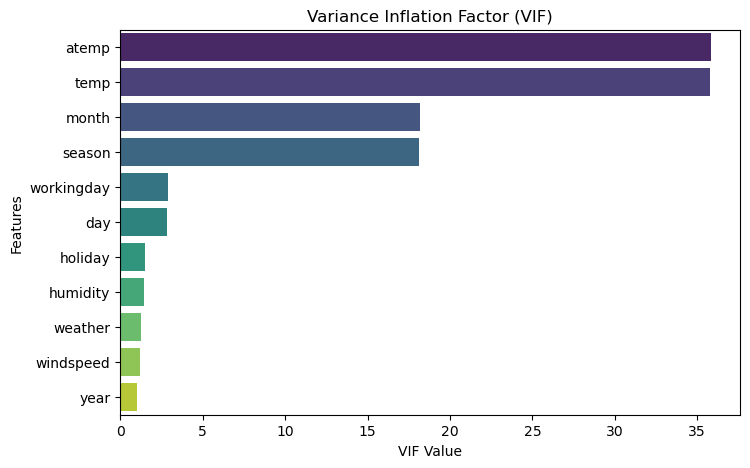

In [36]:
# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    x='VIF', y='feature',
    data=vif_df,
    hue='feature',        # 색상 기준 지정
    dodge=False,          # hue에 따른 위치 분리 방지
    palette='viridis',
    legend=False          # 범례 숨김
)
plt.title('Variance Inflation Factor (VIF)')
plt.xlabel("VIF Value")
plt.ylabel("Features")
plt.show()

In [37]:
# 'atemp' 컬럼 드랍 ('temp'만 사용)
X_train = X_train.drop(columns=['atemp'])
X_test = X_test.drop(columns=['atemp'])

In [38]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')
print(f'R²: {r2}')

residuals = y_test - y_pred

MSE: 21969.509468301803
RMSE: 148.22115054303757
R²: 0.334397183727267


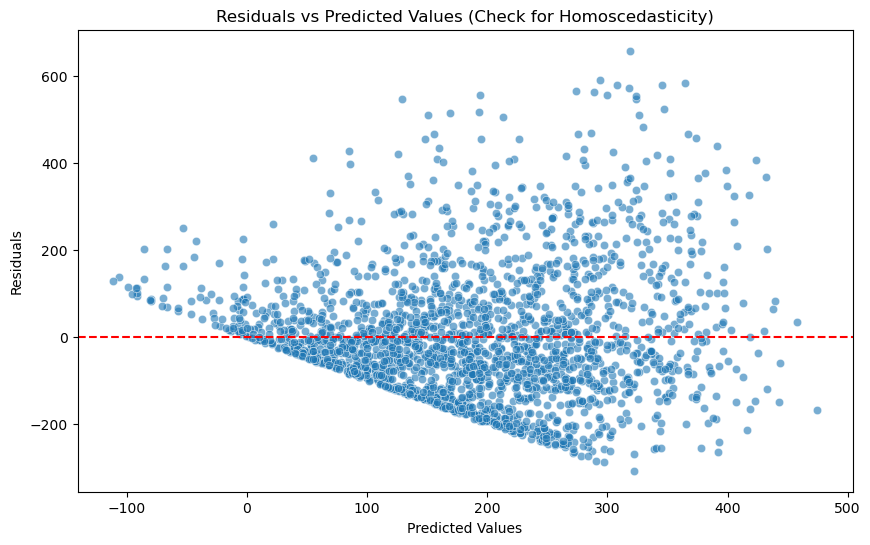

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Check for Homoscedasticity)')
plt.show()

- 잔차가 부채꼴 모양을 띄며 에측값이 커질수록 잔차의 크기도 커지고 있다
    - 등분산성 만족하지 못함

## 문제 3. target(대여량, count) 변수의 분산이 크기때문일까?

In [41]:
y.describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

- 타깃변수의 로그변환

In [50]:
# 타깃 로그 변환
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 모델 훈련
model.fit(X_train, y_train_log)

# 예측 (로그 스케일)
y_pred_log = model.predict(X_test)

# 역변환 후 평가
y_test_orig = np.expm1(y_test_log)
y_pred_orig = np.expm1(y_pred_log)

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_orig)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# 잔차 (원래 스케일)
residuals_orig = y_pred_orig - y_test_orig

# 잔차 (로그 스케일)
residuals_log = y_pred_log - y_test_log

MSE: 26956.985471841635
RMSE: 164.1858260381865
R²: 0.18329330592614868


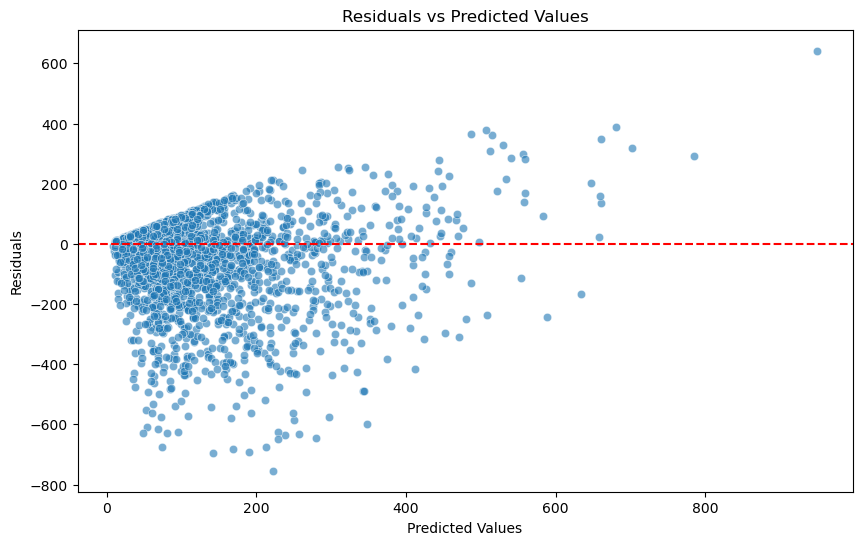

In [53]:
# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_orig, y=residuals_orig, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

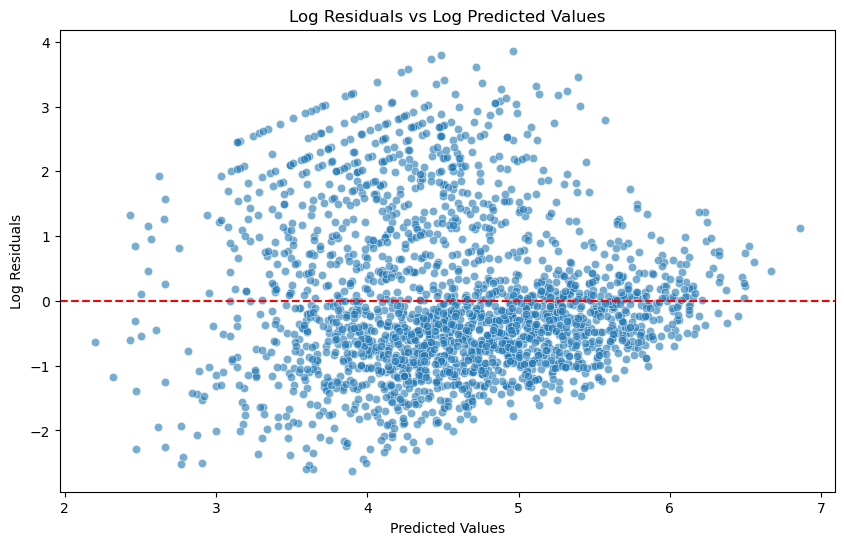

In [54]:
# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log, y=residuals_log, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Log Residuals')
plt.title('Log Residuals vs Log Predicted Values')
plt.show()

- 여전히 잔차 등분산성 위배
    - 타깃 값의 로그 변환을 하더라도 어느정도 개선을 되었지만, 잔차가 등분산성을 만족하지 못하는 (부채꼴, 다이아몬드) 경향을 보임

## 결론
- 선형 회귀 모델 사용 조건
    - 잔차의 등분산성
    - 잔차의 독립성
    - 잔차의 정규성

- 잔차의 등분산성이 심하게 위배되면, 선형 회귀의 예측 및 해석에 주의가 필요
- 비선형 회귀 모델 사용을 고려하는 것이 바람직

# 독립 변수간의 상관관계 조사

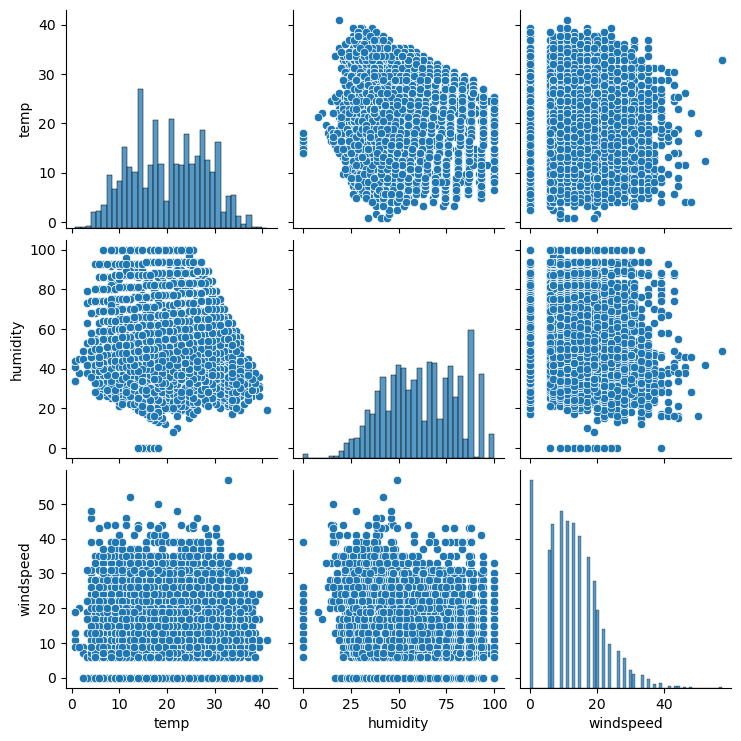

In [88]:
sns.pairplot(objective_variables[['temp', 'humidity', 'windspeed']], diag_kind="hist")
plt.show()